# Начало работы

In [213]:
# Загружаем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from skforecast.preprocessing import TimeSeriesDifferentiator
from statsmodels.tsa.stattools import adfuller

from skforecast.recursive import ForecasterRecursive
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

In [214]:
# Загружаем датасеты

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [215]:
# Работаем с датасетами

train['dt'] = pd.to_datetime(train['dt'])
train = train.set_index('dt').asfreq('W-MON')['pfr']

test['dt'] = pd.to_datetime(test['dt'])
test = test.set_index('dt').asfreq('W-MON')['pfr']

# Строим сезонный, трендовый и прочие графики

In [216]:
# Используем statsmodel

decomposition = seasonal_decompose(train, model='additive', period=52)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

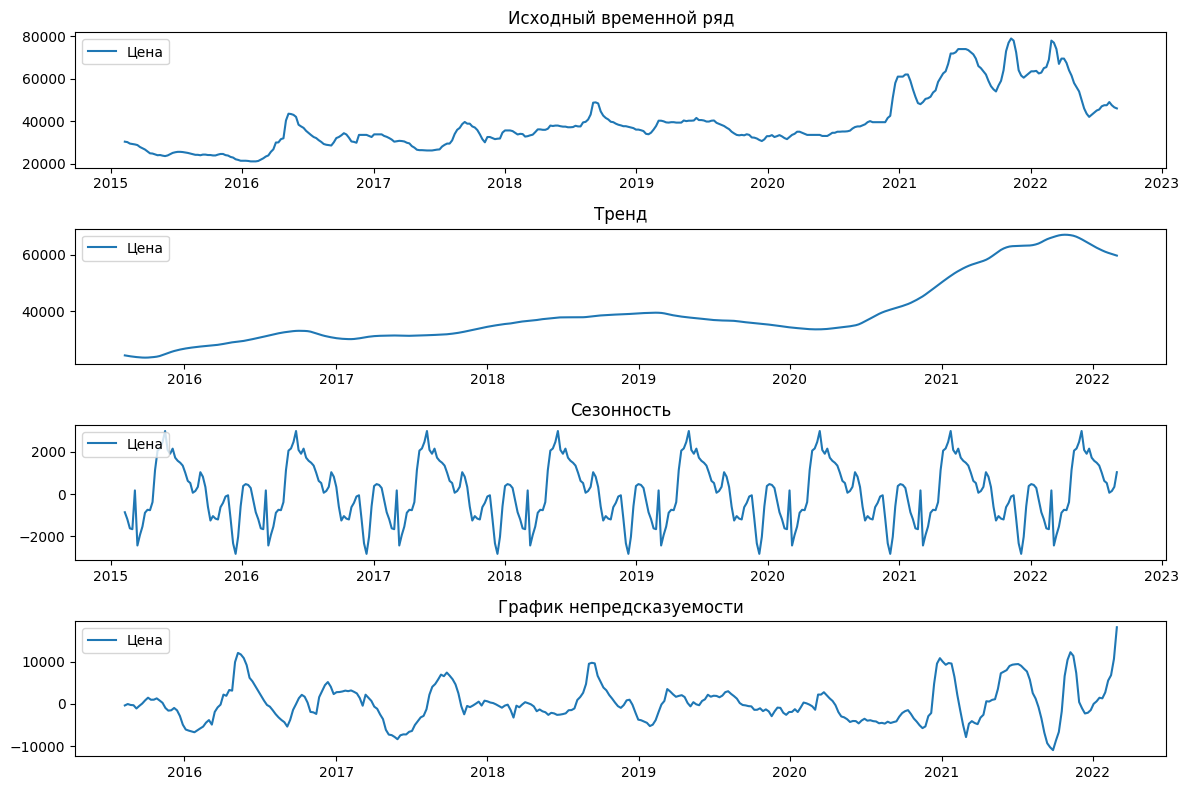

<Figure size 1200x800 with 0 Axes>

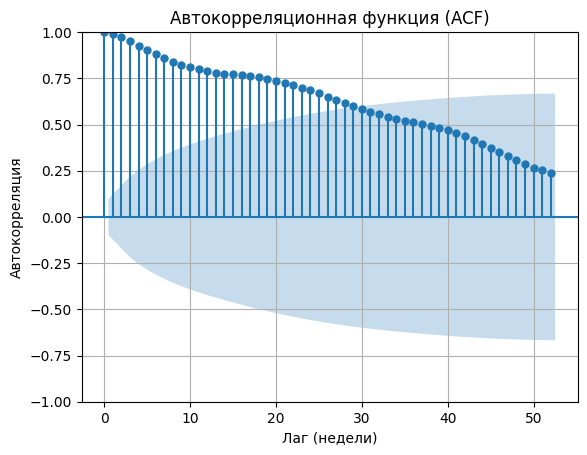

ADF Statistic: -1.950302579833983
p-value: 0.3087794342399395
Critical Values: {'1%': -3.447272819026727, '5%': -2.868998737588248, '10%': -2.5707433189709294}


In [217]:
# Построение графиков

plt.figure(figsize=(12, 8))

# Исходный график

plt.subplot(411)
plt.plot(train, label='Цена')
plt.legend(loc='upper left')
plt.title('Исходный временной ряд')

# График тренда

plt.subplot(412)
plt.plot(trend, label='Цена')
plt.legend(loc='upper left')
plt.title('Тренд')

# График сезонности

plt.subplot(413)
plt.plot(seasonal, label='Цена')
plt.legend(loc='upper left')
plt.title('Сезонность')

# График непредсказуемости

plt.subplot(414)
plt.plot(residual, label='Цена')
plt.legend(loc='upper left')
plt.title('График непредсказуемости')

plt.tight_layout()
plt.show()

# График автокорреляции

plt.figure(figsize=(12, 8))
plot_acf(train, lags=52, alpha=0.05)
plt.title('Автокорреляционная функция (ACF)')
plt.xlabel('Лаг (недели)')
plt.ylabel('Автокорреляция')
plt.grid(True)
plt.show()

# Нестационарность

result = adfuller(train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

In [218]:
# Видим тренды на рост и сезонную зависимость, а также нестационарность

# Исправляем нестационарность

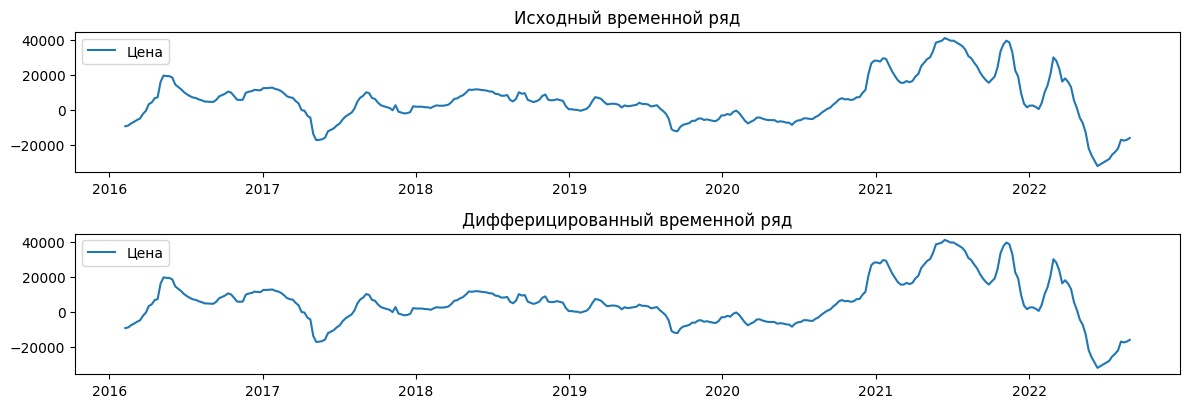

ADF Statistic: -3.655938313308841
p-value: 0.004777382138059506
Critical Values: {'1%': -3.4497304638968043, '5%': -2.8700785273763487, '10%': -2.571319005190311}


In [ ]:
# Сезонное дифферицирование

seasonal_period = 52
train_diff = train.diff(seasonal_period).dropna()

# Построение графиков

plt.figure(figsize=(12, 8))

plt.subplot(413)
plt.plot(train_diff, label='Цена')
plt.legend(loc='upper left')
plt.title('Исходный временной ряд')

plt.subplot(414)
plt.plot(train_diff, label='Цена')
plt.legend(loc='upper left')
plt.title('Дифферицированный временной ряд')

plt.tight_layout()
plt.show()

result_diff = adfuller(train_diff)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:', result_diff[4])

# Обучаем модель

In [220]:
# Определяем простейшую модель
linear_regression = ForecasterRecursive(
    regressor=LinearRegression(),
    lags=24
)

# Обучаем модель
linear_regression.fit(train_diff)

# Строим прогноз
predictions = linear_regression.predict(len(test))

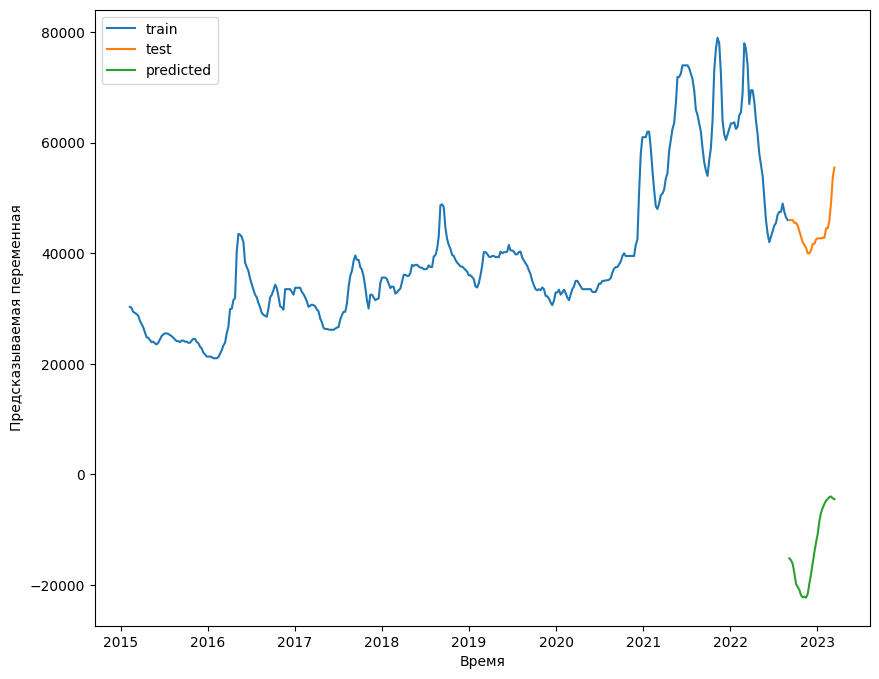

R²: -262.6094
MSE: 3379001924.67
RMSE: 58129.18
MAE: 57830.62
MAPE: 131.46%
SMAPE: 200.00%


In [221]:
# График

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(predictions, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.legend()
plt.show()

# Метрики

r2 = r2_score(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100
smape = np.mean(2 * np.abs(predictions - test) / (np.abs(test) + np.abs(predictions))) * 100

# Выводим метрики

print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")

# Сохраняем обученную модель

In [222]:
# Сохраняем модель

joblib.dump(linear_regression, 'model/linear_regression_model.joblib')

['model/linear_regression_model.joblib']

# Проверяем

In [223]:
# Загружаем модель

loaded_forecaster = joblib.load('model/linear_regression_model.joblib')

# Делаем прогноз

forecast = loaded_forecaster.predict(steps=60)
print(forecast)

2022-09-05   -15200.334250
2022-09-12   -15571.200058
2022-09-19   -16176.423847
2022-09-26   -17895.854923
2022-10-03   -19826.647381
2022-10-10   -20375.929006
2022-10-17   -20919.962937
2022-10-24   -21875.030597
2022-10-31   -22279.656505
2022-11-07   -22120.719811
2022-11-14   -22336.151542
2022-11-21   -21664.372154
2022-11-28   -19777.960251
2022-12-05   -18048.456460
2022-12-12   -16040.899471
2022-12-19   -14087.672323
2022-12-26   -12330.572881
2023-01-02   -10803.689716
2023-01-09    -8442.844767
2023-01-16    -6917.943624
2023-01-23    -6057.718402
2023-01-30    -5340.702896
2023-02-06    -4742.372115
2023-02-13    -4443.950910
2023-02-20    -4118.075251
2023-02-27    -4014.716374
2023-03-06    -4344.456602
2023-03-13    -4502.912095
2023-03-20    -4450.793028
2023-03-27    -4392.020587
2023-04-03    -4049.866124
2023-04-10    -3424.479740
2023-04-17    -2861.458989
2023-04-24    -2338.343303
2023-05-01    -1440.800775
2023-05-08     -468.289943
2023-05-15      621.523872
2

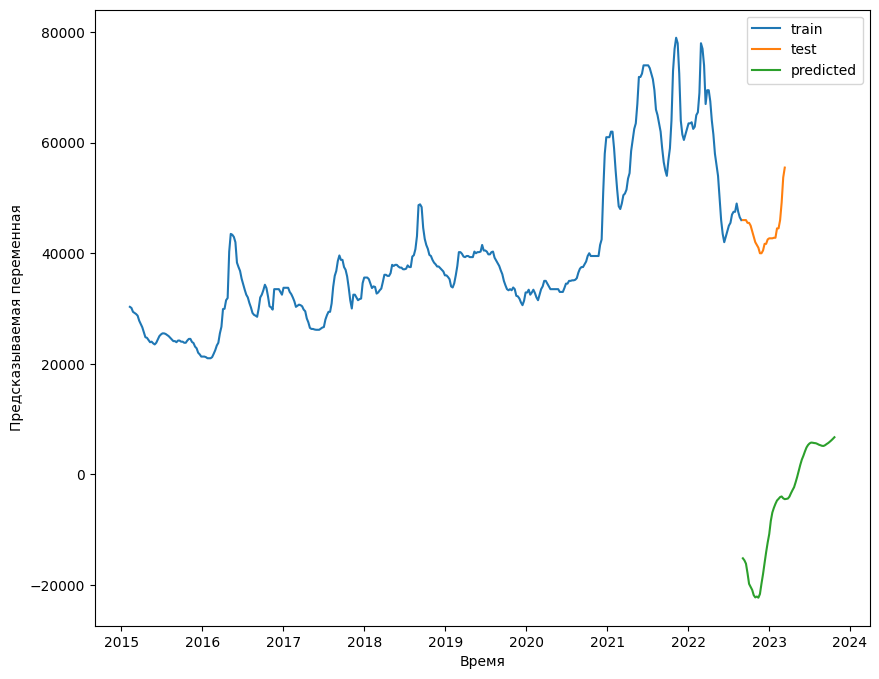

R²: -262.6094
MSE: 3379001924.67
RMSE: 58129.18
MAE: 57830.62
MAPE: 131.46%
SMAPE: 200.00%


In [224]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(forecast, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.legend()
plt.show()

# Метрики
r2 = r2_score(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100
smape = np.mean(2 * np.abs(predictions - test) / (np.abs(test) + np.abs(predictions))) * 100

# Выводим метрики
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")